In [1]:
"""
Computer Vision Mini Project
Author: Raj Antala

Pipeline:
1. Image Acquisition
2. Preprocessing
3. Face Segmentation
4. Feature Extraction (ORB)
5. Feature Matching
6. Classification
7. Non-Maximum Suppression
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(img, title="Image"):
    if len(img.shape) == 2:  # grayscale
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

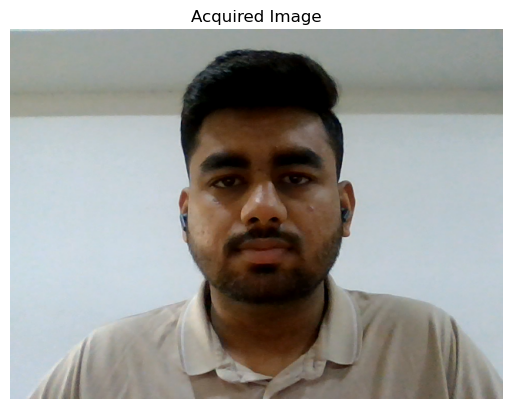

In [4]:
def acquire_image(save_path="acquired_image.jpg"):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Cannot access webcam")

    ret, frame = cap.read()
    cap.release()

    if not ret:
        raise IOError("Failed to capture image")

    cv2.imwrite(save_path, frame)
    show(frame, "Acquired Image")
    return save_path

image_path = acquire_image()


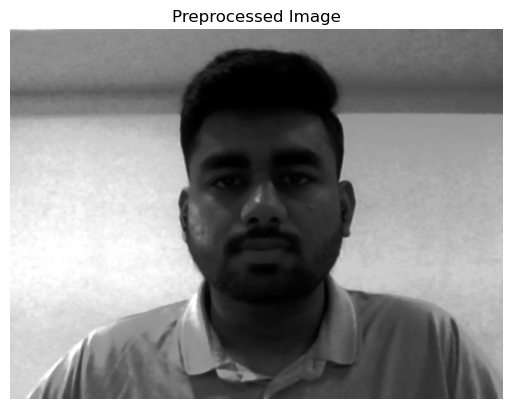

In [5]:
def preprocess_image(image_path, output_path="preprocessed.jpg"):
    img = cv2.imread(image_path)
    if img is None:
        raise IOError("Image not found")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    equalized = cv2.equalizeHist(blur)

    cv2.imwrite(output_path, equalized)
    show(equalized, "Preprocessed Image")
    return output_path

preprocessed_path = preprocess_image(image_path)

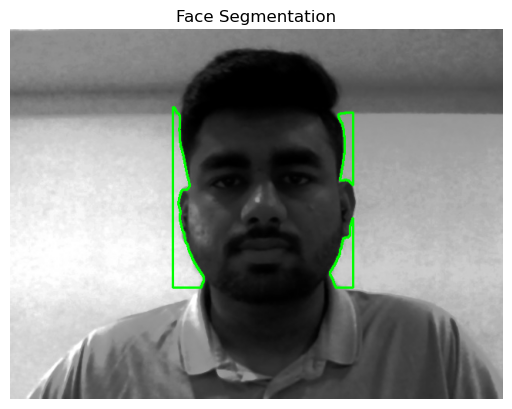

array([[[205, 205, 205],
        [206, 206, 206],
        [205, 205, 205],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [105, 105, 105]],

       [[184, 184, 184],
        [185, 185, 185],
        [184, 184, 184],
        ...,
        [104, 104, 104],
        [105, 105, 105],
        [104, 104, 104]],

       [[155, 155, 155],
        [157, 157, 157],
        [157, 157, 157],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [104, 104, 104]],

       ...,

       [[207, 207, 207],
        [207, 207, 207],
        [208, 208, 208],
        ...,
        [145, 145, 145],
        [145, 145, 145],
        [145, 145, 145]],

       [[205, 205, 205],
        [205, 205, 205],
        [207, 207, 207],
        ...,
        [145, 145, 145],
        [145, 145, 145],
        [146, 146, 146]],

       [[205, 205, 205],
        [205, 205, 205],
        [206, 206, 206],
        ...,
        [146, 146, 146],
        [145, 145, 145],
        [146, 146, 146]]

In [6]:
import numpy as np

def segment_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(80, 80))

    for (x, y, w, h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.GaussianBlur(roi, (5, 5), 0)
        _, roi = cv2.threshold(roi, 0, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = np.ones((3, 3), np.uint8)
        roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel)

        contours, _ = cv2.findContours(
            roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        for c in contours:
            if cv2.contourArea(c) > 300:
                c += [x, y]
                cv2.drawContours(img, [c], -1, (0, 255, 0), 2)

    cv2.imwrite("segmented.jpg", img)
    show(img, "Face Segmentation")
    return img

segment_image(preprocessed_path)

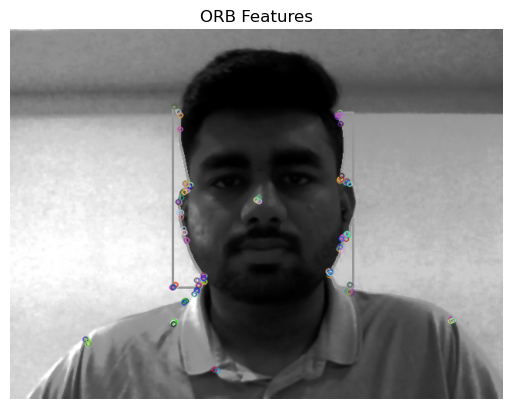

In [7]:
def extract_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Image not found")
        return None, None

    orb = cv2.ORB_create(200, fastThreshold=40)
    kp, des = orb.detectAndCompute(img, None)

    out = cv2.drawKeypoints(img, kp, None)
    show(out, "ORB Features")
    return kp, des

kp, des = extract_features("segmented.jpg")

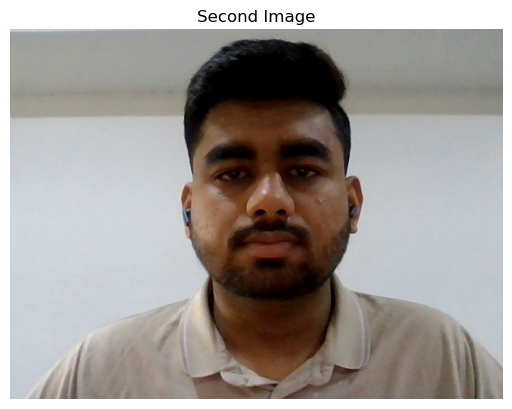

In [8]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if ret:
    cv2.imwrite("image2.jpg", frame)
    show(frame, "Second Image")
cap.release()

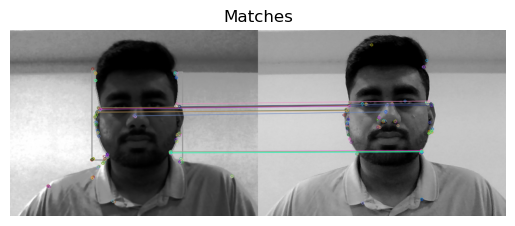

In [9]:
img1 = cv2.imread("segmented.jpg", 0)
img2 = cv2.imread("image2.jpg", 0)

orb = cv2.ORB_create(500, fastThreshold=40)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = sorted(bf.match(des1, des2),
                 key=lambda x: x.distance)

out = cv2.drawMatches(img1, kp1, img2, kp2,
                       matches[:15], None)

show(out, "Matches")

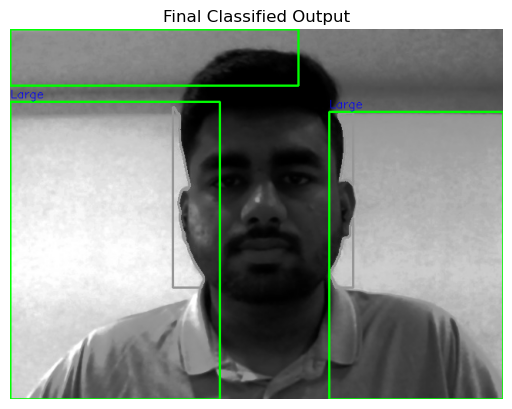

In [10]:
img = cv2.imread("segmented.jpg", 0)
H, W = img.shape

_, bin_img = cv2.threshold(img, 0, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)

cnts, _ = cv2.findContours(
    bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for c in cnts:
    a = cv2.contourArea(c)
    if a < 300 or a > 0.9 * H * W:
        continue

    x, y, w, h = cv2.boundingRect(c)
    label = "Large" if a > 1500 else "Small"

    cv2.rectangle(out, (x, y), (x+w, y+h),
                  (0, 255, 0), 2)
    cv2.putText(out, label, (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (255, 0, 0), 1)

show(out, "Final Classified Output")

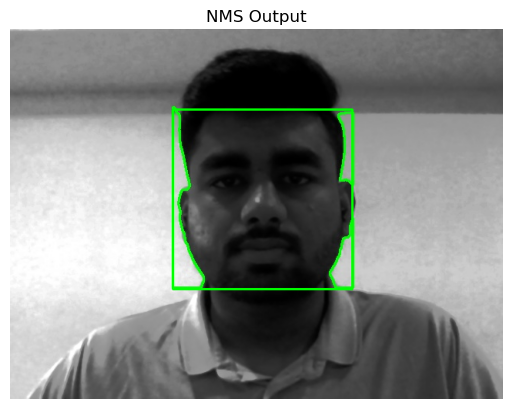

In [11]:
def apply_nms(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

    faces = face.detectMultiScale(gray, 1.1, 5)
    boxes = [[x, y, w, h] for (x, y, w, h) in faces]
    scores = [1.0] * len(boxes)

    if not boxes:
        print("No face detected")
        return

    keep = cv2.dnn.NMSBoxes(boxes, scores, 0.5, 0.4)

    for i in keep.flatten():
        x, y, w, h = boxes[i]
        cv2.rectangle(img, (x, y),
                      (x+w, y+h), (0, 255, 0), 2)

    show(img, "NMS Output")

apply_nms("segmented.jpg")